# ResNet50-Baseline (Public Domain ONLY)

In [1]:
# Import required packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import glob
import imageio
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/researchpaper2023/00_datasets/public_dataset/train_augmented/images/'
LABEL_PATH = '/content/drive/MyDrive/researchpaper2023/00_datasets/public_dataset/train_augmented/labels/'

images = []

for filename in os.listdir(IMAGE_PATH):
  im = imageio.imread(str(IMAGE_PATH) + str(filename), pilmode = 'RGB')
  images.append(im)

print('Total number of Public Domain TRAIN Images: ', len(images)) # 546

Total number of Public Domain TRAIN Images:  546


# Set up data for training

We have a label txt file for each image. If the file is empty, there is no object. If the file is non-empty, there is at least  one object present. Let's create binary training labels. 

The labels are required for our supervised classification task.

In [ ]:
# read in label file
binary_label = []

for filename in os.listdir(LABEL_PATH):
  with open(str(LABEL_PATH)+str(filename)) as f:
    lines = f.readlines()
    if len(lines) == 0:
      binary_label.append(0)
    else:
      binary_label.append(1)

print('Total number of Public Domain Labels:', len(binary_label))
print('Total number of Public Domain Images: ', len(images))

Total number of Public Domain Labels: 546
Total number of Public Domain Images:  546


In [ ]:
VOC_IMAGE_PATH = '/content/drive/MyDrive/researchpaper2023/00_datasets/VOC_dataset/train/images/'
VOC_LABEL_PATH = '/content/drive/MyDrive/researchpaper2023/00_datasets/VOC_dataset/train/labels/'

voc_images = []

for filename in os.listdir(VOC_IMAGE_PATH):
  im = imageio.imread(str(VOC_IMAGE_PATH) + str(filename), pilmode = 'RGB')
  voc_images.append(im)

# read in label file
voc_binary_label = []

for filename in os.listdir(VOC_LABEL_PATH):
  with open(str(VOC_LABEL_PATH)+str(filename)) as f:
    lines = f.readlines()
    if len(lines) == 0:
      voc_binary_label.append(0)
    else:
      voc_binary_label.append(1)

print('Total number of VOC Labels:', len(voc_binary_label))
print('Total number of VOC Images: ', len(voc_images))

Total number of VOC Labels: 700
Total number of VOC Images:  700


In [ ]:
total_images = images + voc_images
total_labels = binary_label + voc_binary_label

In [ ]:
print('Number of 1:', np.count_nonzero(total_labels), "Number of 0: ", len(total_labels) - np.count_nonzero(total_labels))

Number of 1: 546 Number of 0:  700


<AxesSubplot:>

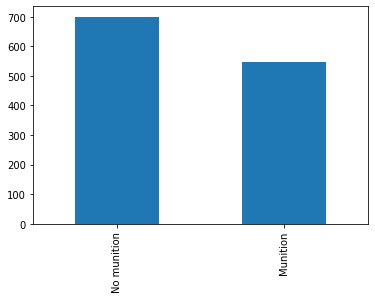

In [ ]:
df = pd.DataFrame({
    'image': filename,
    'category': total_labels
})
df["category"] = df["category"].replace({0: 'No munition', 1: 'Munition'}) 


df['category'].value_counts().plot.bar()

## Train-validation split

X is a list of synthetic images, and y is a list of binary labels.

In [ ]:
print('Total Number of Images:', len(total_images))
print('Total Number of Labels:', len(total_labels))

# Train-validation split while keeping the order of the images
train_data_portion = 0.8

# Get integer number of training samples
train_images_index = round(len(total_images)*train_data_portion)

# Split the dataset in its original sequence
X_train = np.array(total_images[:train_images_index])
y_train = np.array(total_labels[:train_images_index])

X_val = np.array(total_images[train_images_index:])
y_val = np.array(total_labels[train_images_index:])

print('Train-validation split:')
print('{} training images and {} validation images'.format(len(X_train), len(X_val)))

print('Train-validation split:')
print('{} training labels and {} validation labels'.format(len(y_train), len(y_val)))

# There are 4 more labels than there are images, resulting in a potential mismatch between images and labels. 
# Checked the beginning and end of both image and labels folders and they look identical 
# There are duplicates somewhere in the dataset 
# To move forward, I will simply clip the end of the label file so that there are 2160 labels total; this should be addressed for run improvement 

Total Number of Images: 1246
Total Number of Labels: 1246
Train-validation split:
997 training images and 249 validation images
Train-validation split:
997 training labels and 249 validation labels


# Train ResNet-50 model

In [ ]:
from keras.metrics.metrics import FalsePositives
# Copied from https://www.tensorflow.org/guide/keras/preprocessing_layers#image_data_augmentation_2

from tensorflow import keras
from tensorflow.keras import layers

# instantiate and shuffle training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_dataset.shuffle(buffer_size=1024).batch(64)

# instantiate and shuffle validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_dataset.shuffle(buffer_size=1024).batch(64)

In [ ]:
# set model variables 
# copy Forensic Architecture on these parameters
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50
batch_size = 64
loss = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam 
training_epochs = [10, 20]  # setting the number of training epochs
IMG_SIZE = (512, 512) # all images are this size
IMG_SHAPE = IMG_SIZE + (3,) # add a third dimension for RGB channel

# what is the feature space / feature % for each image ; data augmetnation solves this issue

classes = 2
include_top = False
weights = None
pooling = None
learning_rates = [1e-3, 1e-4] # create learning rates for two phases of training 
metrics = [keras.metrics.BinaryAccuracy(), keras.metrics.FalsePositives(),
            keras.metrics.TruePositives(), keras.metrics.FalseNegatives(),
            keras.metrics.TrueNegatives(), keras.metrics.AUC(name='auc')] 
num_of_test_samples = len(X_train)
num_of_validation_samples = len(X_val)
steps_per_epoch = num_of_test_samples // batch_size
print("Steps per epoch: ",steps_per_epoch)

Steps per epoch:  15


In [ ]:
# create a base model from the pre-trained ResNet50
base_model = keras.applications.ResNet50(include_top=include_top, weights=weights, input_shape=IMG_SHAPE, pooling=pooling, classes=classes)
base_model.trainable = False 

In [ ]:
# wrap model around input layer, average pooling layer, dropout layer, and classification layer 
inputs = keras.Input(shape=IMG_SHAPE) # Input layer

x = layers.GlobalAveragePooling2D()(base_model.output) # Pooling layer ; Ishaani: pooling is reducing the dimensions,  you are retaining information while removing pixels from image, keep for optimization
x = layers.Dropout(0.1)(x) # Dropout layer ; Ishaani: definitely would optmize to some extent

output = layers.Dense(1, activation="sigmoid")(x) # Classification layer 

In [ ]:
# build the model
model = keras.models.Model(inputs=[base_model.input], outputs=[output]) 

In [ ]:
# Print out a summary of the model created.
model.summary() # Ishaani: take a look at how to read these summaries, take a look and see what it means

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# Plot the model layers' dependency graph and each layer's input-output shape.
keras.utils.plot_model(model, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Load pre-trained model weights
# expect_partial() tells the function that we are only loading the weights, not the whole training history
# model.load_weights('path/to/model').expect_partial()

We are going to use the typical transfer-learning workflow:
1. Phase 1: Fix ResNet50's weights, only update the last classification layer's weights.
2. Phase 2: Fine tuning. Allow some of ResNet50's weights to update as well.

## Phase 1: ResNet50 fixed

In [ ]:
# Phase 1: ResNet50's weights fixed

# Compile the model
model.compile(
    optimizer=optimizer(learning_rates[0]),
    loss=loss,
    metrics=metrics,
)

# Train the model
phase_1_history = model.fit(
    train_ds, 
    epochs=training_epochs[0], 
    validation_data=val_ds
)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 [==============================] - 20s 350ms/step - loss: 1.9612 - binary_accuracy: 0.5216 - false_positives: 256.0000 - true_positives: 325.0000 - false_negatives: 221.0000 - true_negatives: 195.0000 - auc: 0.5229 - val_loss: 1.4468 - val_binary_accuracy: 0.0000e+00 - val_false_positives: 249.0000 - val_true_positives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_true_negatives: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/10
16/16 [==============================] - 2s 153ms/step - loss: 1.6058 - binary_accuracy: 0.5216 - false_positives: 273.0000 - true_positives: 342.0000 - false_negatives: 204.0000 - true_negatives: 178.0000 - auc: 0.5289 - val_loss: 0.7882 - val_binary_accuracy: 0.3414 - val_false_positives: 164.0000 - val_true_positives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_true_negatives: 85.0000 - val_auc: 0.0000e+00
Epoch 3/10
16/16 [==============================] - 2s 154ms/step - loss: 1.5866 - binary_accuracy: 0.5356 - false_positives: 238.0000 - true

Next let's plot loss and accuracy for training and validation sets

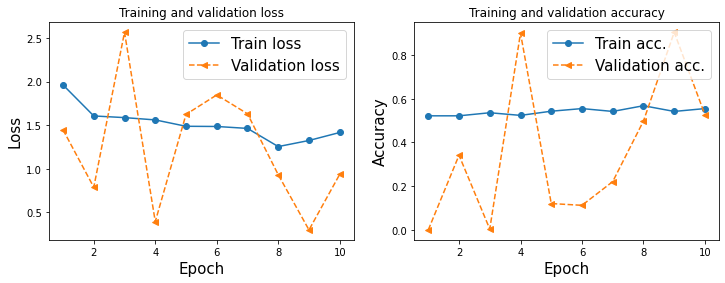

In [ ]:
hist = phase_1_history.history
# print(phase_1_history.history.keys())

x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
plt.title('Training and validation loss')

print('\n')
print('\n')

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['binary_accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_binary_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.title('Training and validation accuracy')
plt.show()

# Ishaani: with a few tweaks, you should see improvement. Worst case: won't behave, add optimization steps; Meta-Heuristic optimizer ; if you can explain the a-ha moment. 

In [ ]:
# save the model
index = 0 
p = '/content/drive/MyDrive/researchpaper2023/01_scripts/baselineCNN/phase1_results/baseline_phase1_run' + str(index) 

while os.path.exists(p):
  index += 1
  p = '/content/drive/MyDrive/researchpaper2023/01_scripts/baselineCNN/phase1_results/baseline_phase1_run' + str(index) 

os.makedirs(p)
model.save(str(p))
print("The latest Phase1 Baseline Model is saved here:", str(p))

The latest Phase1 Baseline Model is saved here: /content/drive/MyDrive/researchpaper2023/01_scripts/baselineCNN/phase1_results/baseline_phase1_run1


## Phase 2: Fine tuning

Now let's unfreeze some layers of ResNet50 and allow them to be trained with data. This is done by setting the layer's `trainable` attribute to `True`.

In [ ]:
# Phase 2: Fine tuning
model.trainable = True

fine_tune_at = 0
for layer in model.layers[:fine_tune_at]:
    layer.trainable =  False 

In [ ]:
# phase 2 compile

# Ishaani: when you use Adam, you indicate that it is taking the best one by default, whereas SGD may take it's own default optimizer (sequential, etc.) 

# optimizer is Adam; nature-inspired algorithims, mimics behavior from nature; it is not a part of current neural networks Adadelta, Nadam, Adamax, RMSprop, and Adadelta. ; Classification of EMG signals using PSO optimized SVM for diagnosis of neuromuscular disorders

model.compile(
    optimizer=optimizer(learning_rates[1]), 
    loss=loss,
    metrics=metrics)

# phase 2 train
phase_2_history = model.fit(
    train_ds,
    epochs=sum(training_epochs),
    initial_epoch=phase_1_history.epoch[-1], 
    validation_data = val_ds)

Epoch 10/30


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 [==============================] - 49s 589ms/step - loss: 1.6548 - binary_accuracy: 0.5722 - false_positives: 303.0000 - true_positives: 316.0000 - false_negatives: 230.0000 - true_negatives: 397.0000 - auc: 0.5979 - val_loss: 2.5404e-37 - val_binary_accuracy: 1.0000 - val_false_positives: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_true_negatives: 249.0000 - val_auc: 0.0000e+00
Epoch 11/30
16/16 [==============================] - 7s 419ms/step - loss: 0.4413 - binary_accuracy: 0.7823 - false_positives: 107.0000 - true_positives: 436.0000 - false_negatives: 110.0000 - true_negatives: 344.0000 - auc: 0.8729 - val_loss: 0.0040 - val_binary_accuracy: 1.0000 - val_false_positives: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_true_negatives: 249.0000 - val_auc: 0.0000e+00
Epoch 12/30
16/16 [==============================] - 7s 418ms/step - loss: 0.3002 - binary_accuracy: 0.8716 - false_positives: 72.0000 - 

In [ ]:
# save the model
index = 0 
p = '/content/drive/MyDrive/researchpaper2023/01_scripts/baselineCNN/phase2_results/phase2_run' + str(index) 

while os.path.exists(p):
  index += 1
  p = '/content/drive/MyDrive/researchpaper2023/01_scripts/baselineCNN/phase2_results/phase2_run' + str(index) 

os.makedirs(p)
model.save(str(p))
print('The latest finetuned model is saved here:', str(p))

The latest finetuned model is saved here: /content/drive/MyDrive/researchpaper2023/01_scripts/baselineCNN/phase2_results/phase2_run11


Next let's plot loss and accuracy for training and validation sets

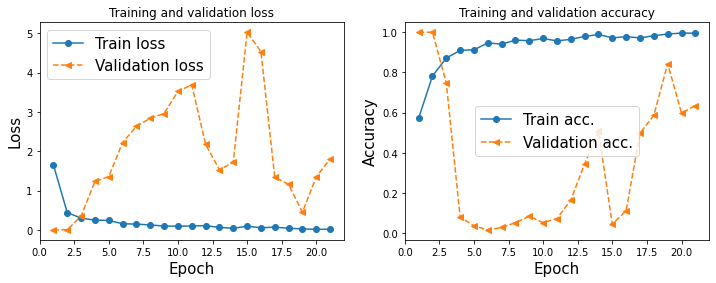

In [ ]:
hist = phase_2_history.history

x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
plt.title('Training and validation loss')

print('\n')
print('\n')

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['binary_accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_binary_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.title('Training and validation accuracy')
plt.show()

# this is an error in the code, has nothing to do with the data 
# try removing pooling and dropout layers and check results 
# if it doesn't improve, look at other ResNet githubs and Kaggle to see how their performance worked
# fix graph for validation loss - fix orange line

In [ ]:
# from dictionary create a pd dataframe and save it as csv to a filepath
def save_dict_as_csv(dict, filepath):
    df = pd.DataFrame(dict)
    df.to_csv(filepath, index=False)
    print('saved dictionary as csv to: ', filepath)

In [ ]:
# save Training Accuracy and Training Loss in csv 

keys = []
for key in hist.keys():
    keys.append(key)

filepath = '/content/drive/MyDrive/researchpaper2023/04_results/baseline_resnet50_acc_loss_train_df02.csv'

save_dict_as_csv(hist, filepath)

saved dictionary as csv to:  /content/drive/MyDrive/researchpaper2023/04_results/baseline_resnet50_acc_loss_train_df02.csv


# Model performance

In [ ]:
# Defining path to the trained model
path_to_trained_model = '/content/drive/MyDrive/researchpaper2023/01_scripts/baselineCNN/phase2_results/phase2_run9'

# Load the trained model
trained_model = keras.models.load_model(path_to_trained_model)

In [ ]:
trained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## Load test data

In [ ]:
TEST_IMAGE_PATH = '/content/drive/MyDrive/researchpaper2023/00_datasets/testaug_voc_combined/test/images/'
TEST_LABEL_PATH = '/content/drive/MyDrive/researchpaper2023/00_datasets/testaug_voc_combined/test/labels/' 

test_images = []

for filename in os.listdir(TEST_IMAGE_PATH):
  im = imageio.imread(str(TEST_IMAGE_PATH) + str(filename), pilmode = 'RGB')
  test_images.append(im)

print('Total number of Public Domain Test Images: ', len(test_images)) 

# read in label file
test_binary_label = []

for filename in os.listdir(TEST_LABEL_PATH):
  with open(str(TEST_LABEL_PATH)+str(filename)) as f:
    lines = f.readlines()
    if len(lines) == 0:
      test_binary_label.append(0)
    else:
      test_binary_label.append(1)

test_binary_label = np.array(test_binary_label)
print('Total number of labels:', len(test_binary_label))
print('First 5 test_binary_label items:', test_binary_label[:5])
print('Number of 1:', np.count_nonzero(test_binary_label), "Number of 0: ", len(test_binary_label) - np.count_nonzero(test_binary_label))

X_test = np.array(test_images)
y_test = np.array(test_binary_label)

# instantiate test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


Total number of Public Domain Test Images:  1252
Total number of labels: 1252
First 5 test_binary_label items: [0 0 0 0 0]
Number of 1: 252 Number of 0:  1000


## Make predictions on test data

In [ ]:
test_results = trained_model.evaluate(X_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

/usr/local/lib/python3.8/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


40/40 [==============================] - 5s 72ms/step - loss: 4.8443 - binary_accuracy: 0.3067 - false_positives: 857.0000 - true_positives: 241.0000 - false_negatives: 11.0000 - true_negatives: 143.0000 - auc: 0.6599

Test Acc. 30.67%


########################################################################

########################################################################

########################################################################